# Capstone Project

## Import Semua Packages/Library yang Digunakan

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

## Data Preparation

### Data Loading

In [39]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d fedesoriano/stroke-prediction-dataset
!unzip stroke-prediction-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset
License(s): copyright-authors
  0% 0.00/67.4k [00:00<?, ?B/s]
100% 67.4k/67.4k [00:00<00:00, 130MB/s]
Archive:  stroke-prediction-dataset.zip
  inflating: healthcare-dataset-stroke-data.csv  


In [40]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.drop(['id', 'work_type'], axis=1, inplace=True)
df

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Urban,83.75,NaN,never smoked,0
5106,Female,81.0,0,0,Yes,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Rural,166.29,25.6,formerly smoked,0


### Data Cleaning

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   Residence_type     5110 non-null   object 
 6   avg_glucose_level  5110 non-null   float64
 7   bmi                4909 non-null   float64
 8   smoking_status     5110 non-null   object 
 9   stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 399.3+ KB


In [42]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [43]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

for col in cat_cols:
    print(f"\n=== Fitur: {col} ===")
    vc = df[col].value_counts(dropna=False)
    pct = df[col].value_counts(normalize=True, dropna=False).mul(100).round(2)
    summary = pd.DataFrame({
        'count': vc,
        'percent (%)': pct
    })
    print(summary)


=== Fitur: gender ===
        count  percent (%)
gender                    
Female   2994        58.59
Male     2115        41.39
Other       1         0.02

=== Fitur: ever_married ===
              count  percent (%)
ever_married                    
Yes            3353        65.62
No             1757        34.38

=== Fitur: Residence_type ===
                count  percent (%)
Residence_type                    
Urban            2596         50.8
Rural            2514         49.2

=== Fitur: smoking_status ===
                 count  percent (%)
smoking_status                     
never smoked      1892        37.03
Unknown           1544        30.22
formerly smoked    885        17.32
smokes             789        15.44


In [44]:
df = df[df['gender'] != 'Other'].copy()

#### Handling Missing Value

In [45]:
df.isna().sum()

,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
Residence_type,0
avg_glucose_level,0
bmi,201
smoking_status,0
stroke,0


In [46]:
imp_median = SimpleImputer(strategy='median')
df[['bmi']] = imp_median.fit_transform(df[['bmi']])

#### Handling Imbalance Dataset

In [47]:
df_majority = df[df.stroke == 0]
df_minority = df[df.stroke == 1]

minority_groups = df_minority.groupby(['heart_disease', 'hypertension'])

upsampled = []
for name, group in minority_groups:
    n_samples = df_majority.shape[0] // minority_groups.ngroups
    upsampled_group = resample(
        group,
        replace=True,
        n_samples=n_samples,
        random_state=42
    )
    upsampled.append(upsampled_group)

upsampled_minority = pd.concat(upsampled)
df = pd.concat([df_majority, upsampled_minority])

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print("\nShape df:", df.shape)
df.head()


Shape df: (9720, 10)


,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Female,56.00,0,0,Yes,Urban,77.49,36.0,formerly smoked,0
1,Female,81.00,0,0,No,Urban,70.30,25.8,smokes,1
2,Female,1.88,0,0,No,Rural,100.74,18.6,Unknown,0
3,Female,10.00,0,0,No,Rural,93.29,20.6,Unknown,0
4,Female,52.00,1,0,Yes,Urban,233.29,48.9,never smoked,1


### Exploratory Data Analysis

#### Univariate Analysis

In [48]:
numerical_features = df.select_dtypes(include='number').columns
categorical_features = df.select_dtypes(include='object').columns.to_list()


Univariate summary for 'gender':
        jumlah sampel  persentase
gender                           
Female           5329        54.8
Male             4391        45.2


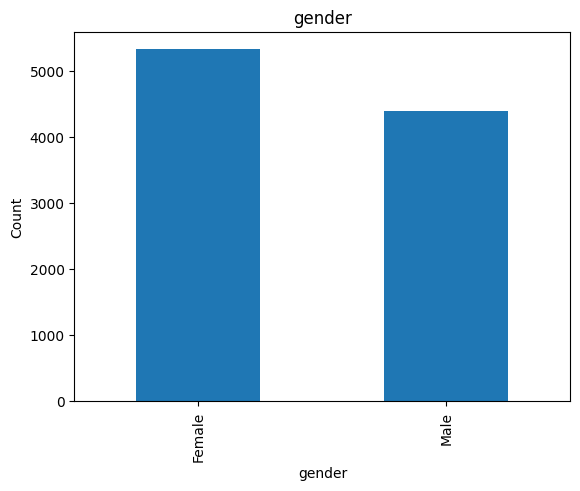


Univariate summary for 'ever_married':
              jumlah sampel  persentase
ever_married                           
Yes                    7253        74.6
No                     2467        25.4


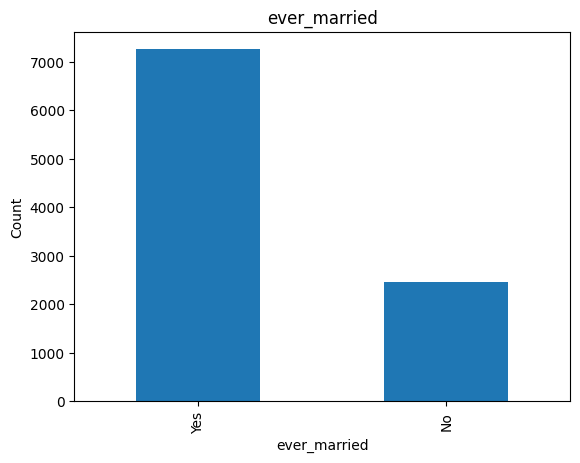


Univariate summary for 'Residence_type':
                jumlah sampel  persentase
Residence_type                           
Urban                    5101        52.5
Rural                    4619        47.5


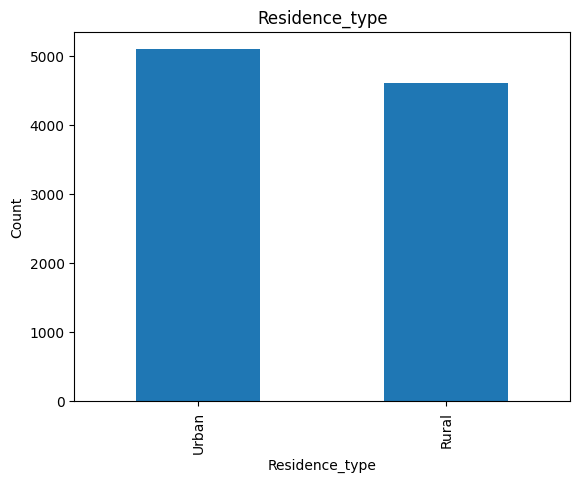


Univariate summary for 'smoking_status':
                 jumlah sampel  persentase
smoking_status                            
never smoked              3536        36.4
formerly smoked           2170        22.3
Unknown                   2152        22.1
smokes                    1862        19.2


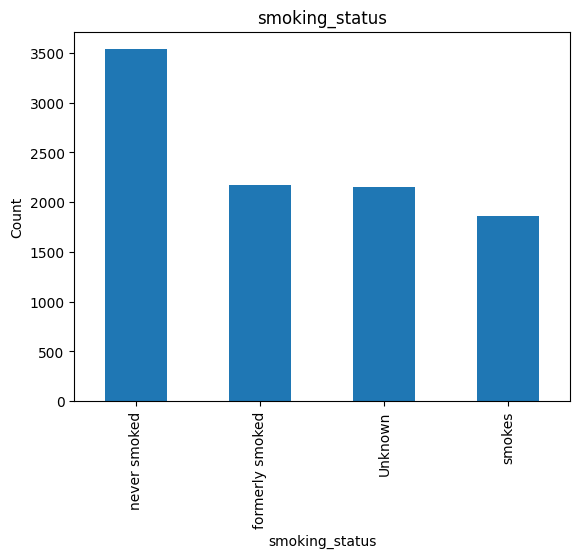

In [49]:
for feature in categorical_features:
    count = df[feature].value_counts()
    percent = 100 * df[feature].value_counts(normalize=True)

    summary_df = pd.DataFrame({
        'jumlah sampel': count,
        'persentase': percent.round(1)
    })
    print(f"\nUnivariate summary for '{feature}':")
    print(summary_df)

    count.plot(kind='bar', title=feature)
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.show()

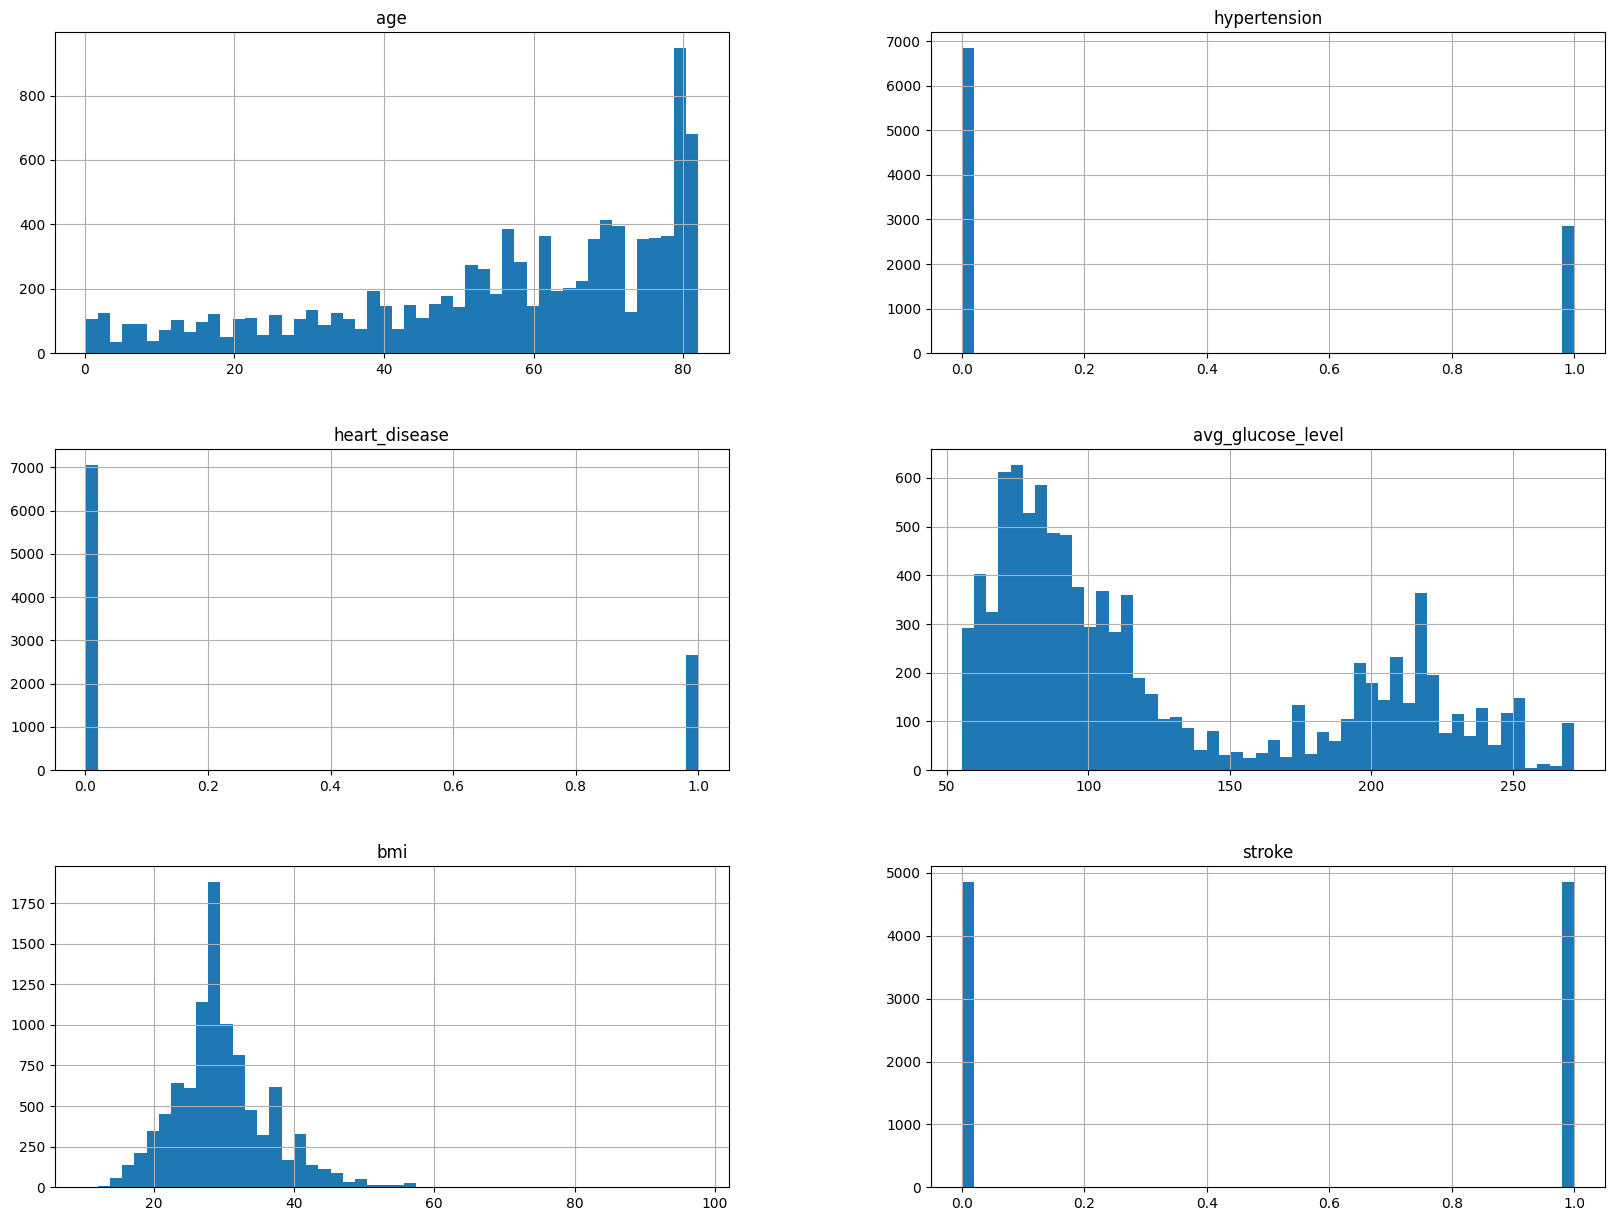

In [50]:
df.hist(bins=50, figsize=(20,15))
plt.show()

#### Multivariate Analysis

<ipython-input-51-aac79afcc83c>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(x=col, y="stroke", kind="bar", dodge=False, height = 4, aspect = 3,  data=df, palette="Set3")
<ipython-input-51-aac79afcc83c>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(x=col, y="stroke", kind="bar", dodge=False, height = 4, aspect = 3,  data=df, palette="Set3")
<ipython-input-51-aac79afcc83c>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(x=col, y="stroke", kind="bar", dodge=False, height = 4, aspect = 3,  data=df, palette="Set3")
<ipython-input-51-aac7

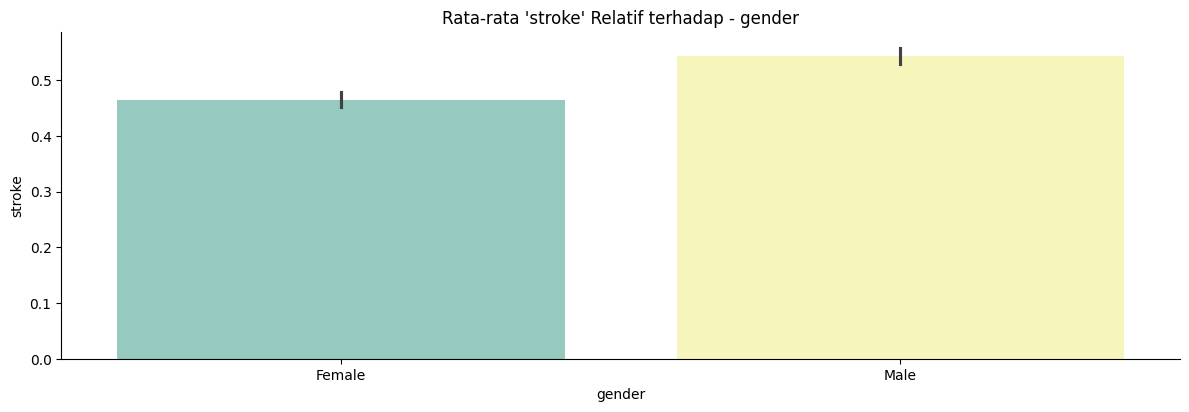

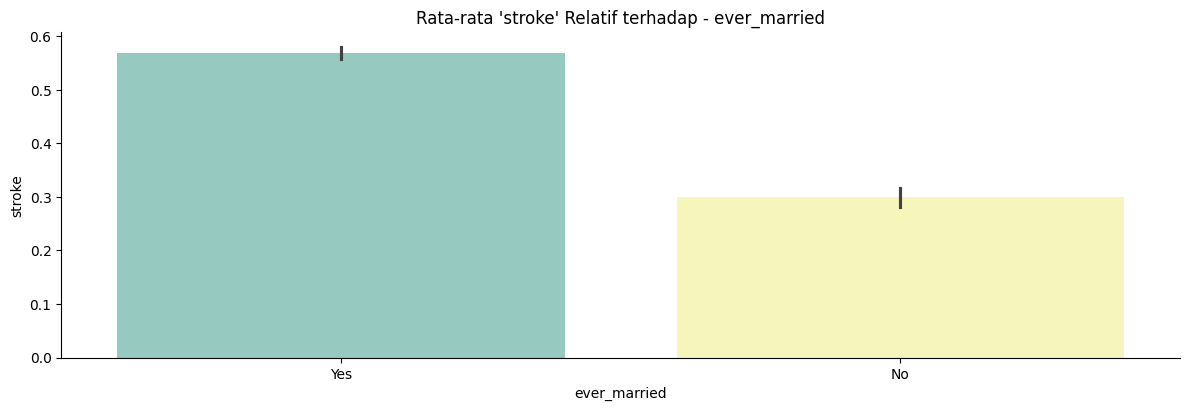

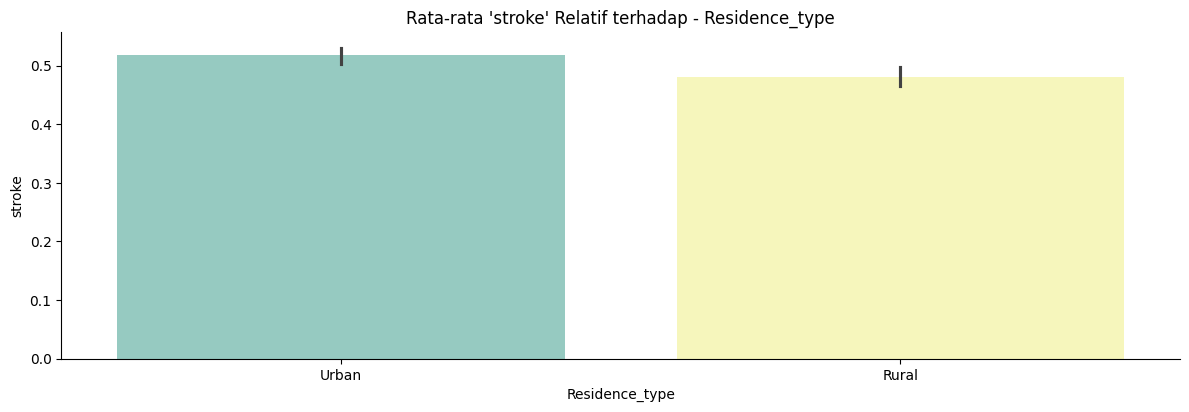

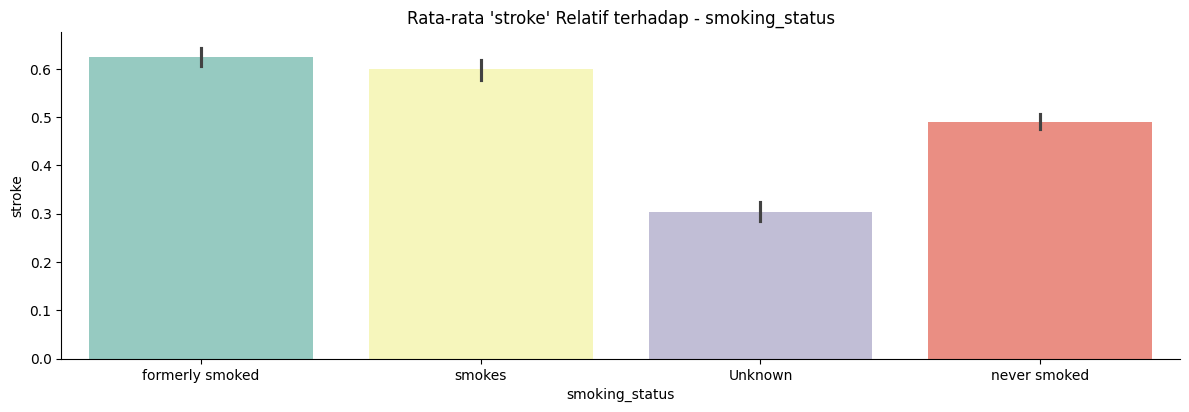

In [51]:
for col in categorical_features:
  sns.catplot(x=col, y="stroke", kind="bar", dodge=False, height = 4, aspect = 3,  data=df, palette="Set3")
  plt.title("Rata-rata 'stroke' Relatif terhadap - {}".format(col))

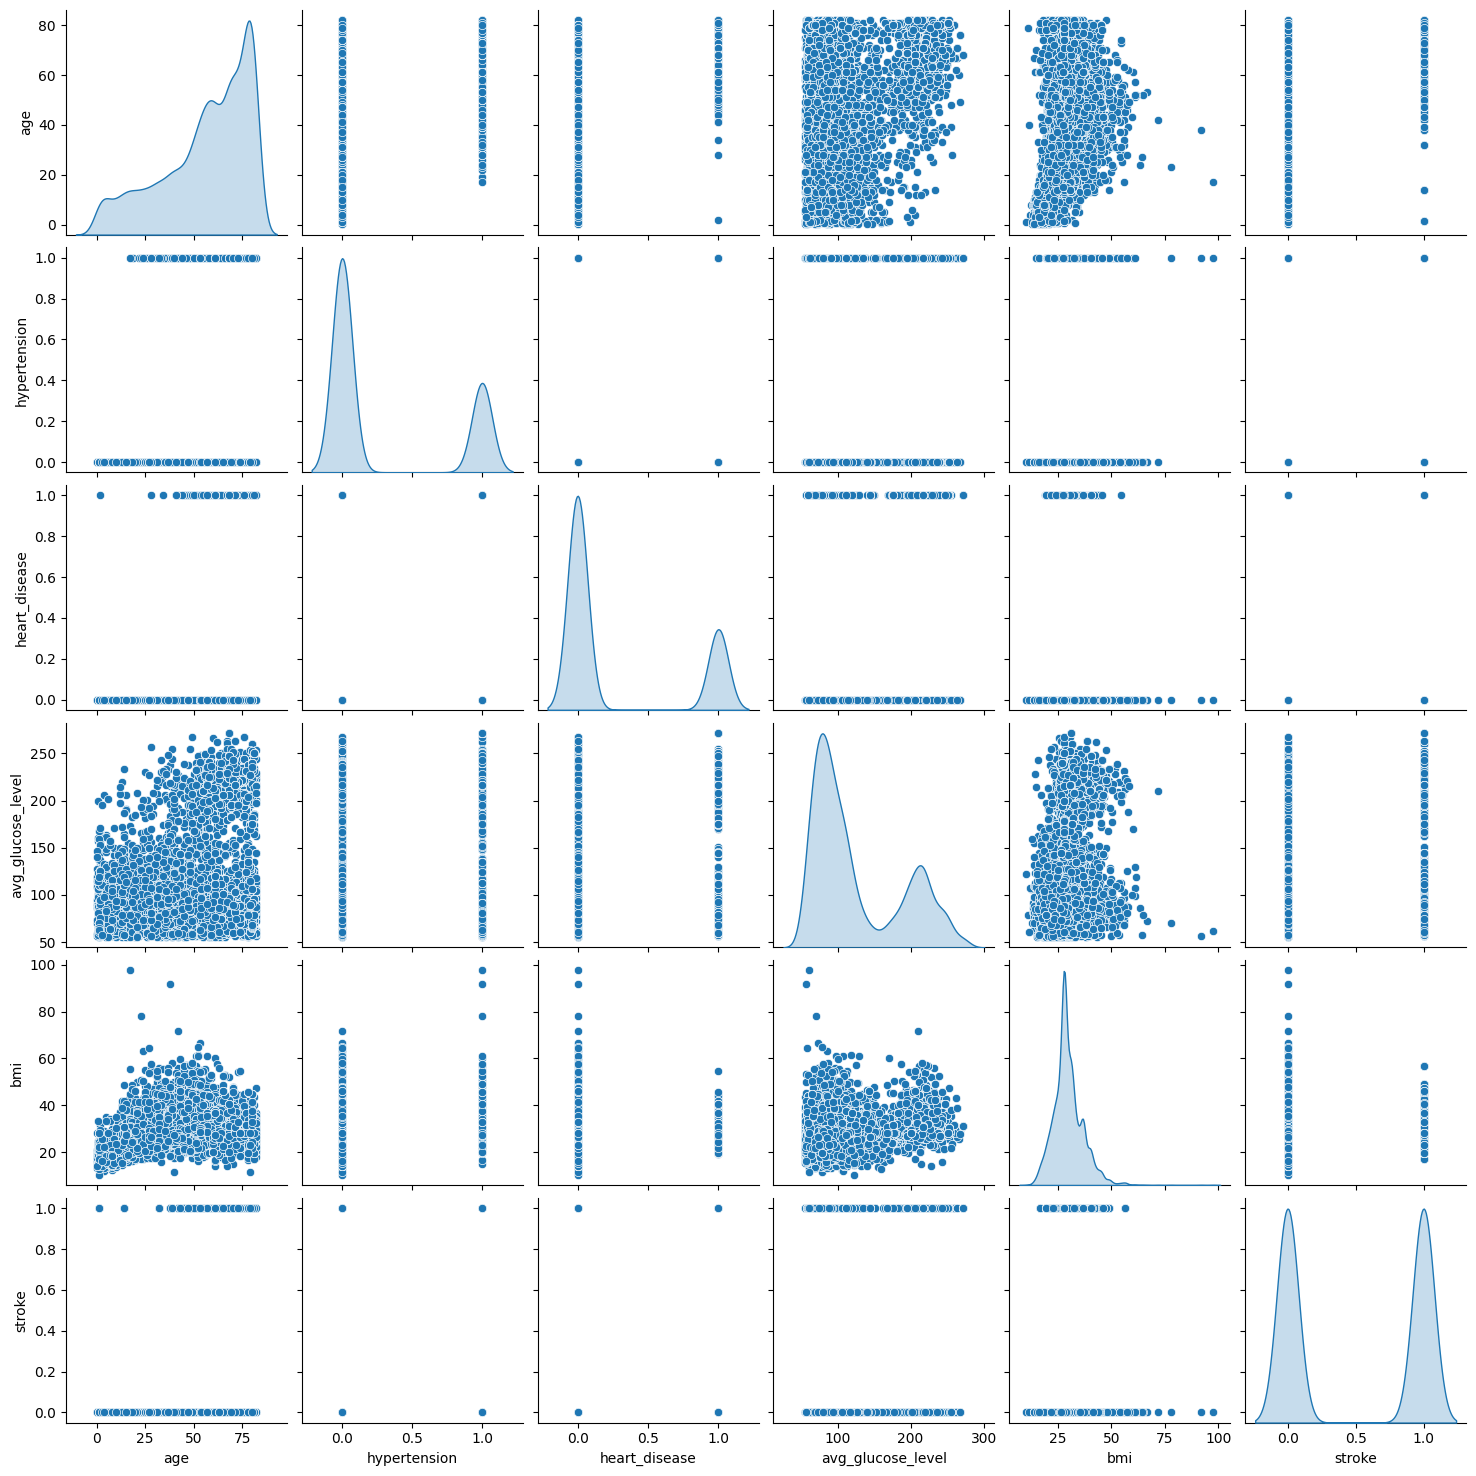

In [52]:
sns.pairplot(df, diag_kind = 'kde')

Text(0.5, 1.0, 'Correlation Matrix untuk Fitur Numerik ')

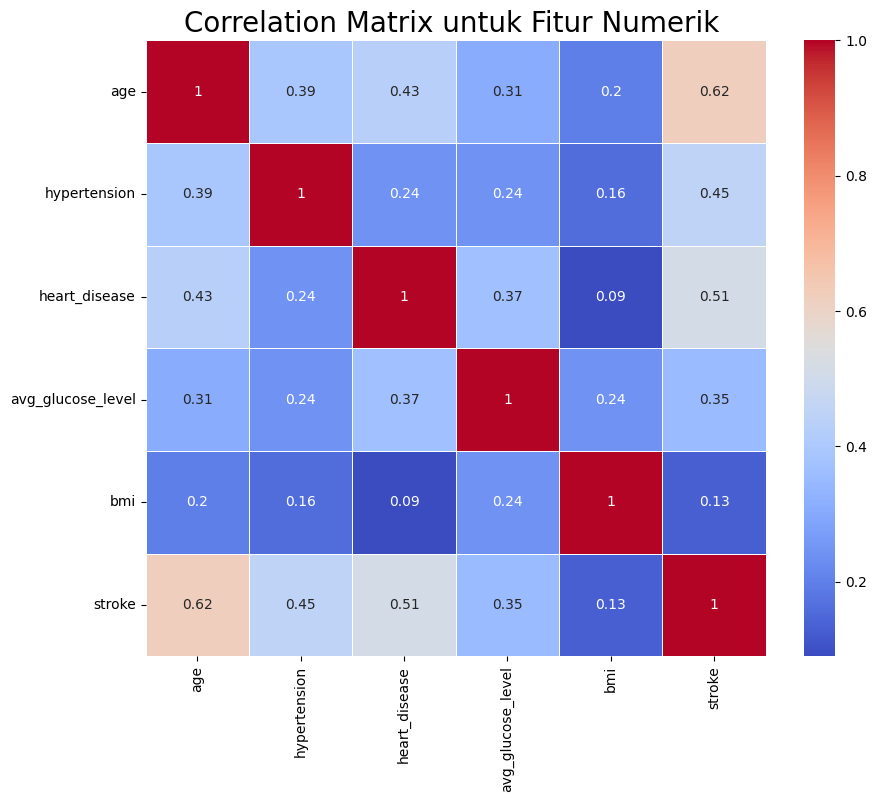

In [53]:
plt.figure(figsize=(10, 8))
correlation_matrix = df[numerical_features].corr().round(2)

sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, )
plt.title("Correlation Matrix untuk Fitur Numerik ", size=20)

## Data Pre-Processing

In [54]:
df_encoded = pd.get_dummies(df, columns=categorical_features)
df_encoded

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,ever_married_No,ever_married_Yes,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,56.00,0,0,77.49,36.0,0,True,False,False,True,False,True,False,True,False,False
1,81.00,0,0,70.30,25.8,1,True,False,True,False,False,True,False,False,False,True
2,1.88,0,0,100.74,18.6,0,True,False,True,False,True,False,True,False,False,False
3,10.00,0,0,93.29,20.6,0,True,False,True,False,True,False,True,False,False,False
4,52.00,1,0,233.29,48.9,1,True,False,False,True,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9715,74.00,0,0,60.98,28.1,1,False,True,False,True,True,False,False,False,True,False
9716,65.00,0,0,205.77,46.0,1,True,False,False,True,False,True,False,True,False,False
9717,79.00,0,0,88.92,22.9,1,True,False,True,False,True,False,False,False,True,False
9718,27.00,0,0,93.55,41.6,0,True,False,True,False,False,True,False,False,True,False


In [55]:
def cha2ds2vasc(row):
    score = 0
    score += int(row['heart_disease'])
    score += int(row['hypertension'])
    if row['age'] >= 75:
        score += 2
    elif row['age'] >= 65:
        score += 1
    if 'gender_Male' in row and row['gender_Male'] == 0:
        score += 1
    return score

In [56]:
df['cha2ds2vasc_score'] = df.apply(cha2ds2vasc, axis=1)

In [57]:
X = df_encoded.drop(columns='stroke')
y = df_encoded['stroke']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Total sample semua dataset: {len(X)}')
print(f'Total sample train dataset: {len(X_train)}')
print(f'Total sample test dataset: {len(X_test)}')

Total sample semua dataset: 9720
Total sample train dataset: 7776
Total sample test dataset: 1944


In [59]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Modelling

In [60]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') > 0.92:
            print("\nAkurasi telah mencapai > 92%!")
            self.model.stop_training = True

callbacks = myCallback()

In [61]:
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.003),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,185 (51.50 KB)

 Trainable params: 12,801 (50.00 KB)

 Non-trainable params: 384 (1.50 KB)

In [62]:
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=128,
    validation_split=0.2,
    callbacks=[callbacks],
    verbose=2
)

Epoch 1/200
49/49 - 3s - 66ms/step - accuracy: 0.7957 - loss: 0.4516 - val_accuracy: 0.7108 - val_loss: 0.5915
Epoch 2/200
49/49 - 0s - 5ms/step - accuracy: 0.8331 - loss: 0.3730 - val_accuracy: 0.8162 - val_loss: 0.5292
Epoch 3/200
49/49 - 0s - 5ms/step - accuracy: 0.8392 - loss: 0.3664 - val_accuracy: 0.8297 - val_loss: 0.4797
Epoch 4/200
49/49 - 0s - 6ms/step - accuracy: 0.8463 - loss: 0.3536 - val_accuracy: 0.8387 - val_loss: 0.4252
Epoch 5/200
49/49 - 0s - 6ms/step - accuracy: 0.8452 - loss: 0.3490 - val_accuracy: 0.8425 - val_loss: 0.4170
Epoch 6/200
49/49 - 0s - 6ms/step - accuracy: 0.8421 - loss: 0.3505 - val_accuracy: 0.8342 - val_loss: 0.3883
Epoch 7/200
49/49 - 0s - 7ms/step - accuracy: 0.8513 - loss: 0.3382 - val_accuracy: 0.8425 - val_loss: 0.3634
Epoch 8/200
49/49 - 0s - 6ms/step - accuracy: 0.8514 - loss: 0.3367 - val_accuracy: 0.8458 - val_loss: 0.3541
Epoch 9/200
49/49 - 0s - 5ms/step - accuracy: 0.8500 - loss: 0.3375 - val_accuracy: 0.8522 - val_loss: 0.3487
Epoch 10/

## Evaluasi dan Visualisasi

In [63]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.89      0.93       971
           1       0.90      0.97      0.93       973

    accuracy                           0.93      1944
   macro avg       0.93      0.93      0.93      1944
weighted avg       0.93      0.93      0.93      1944



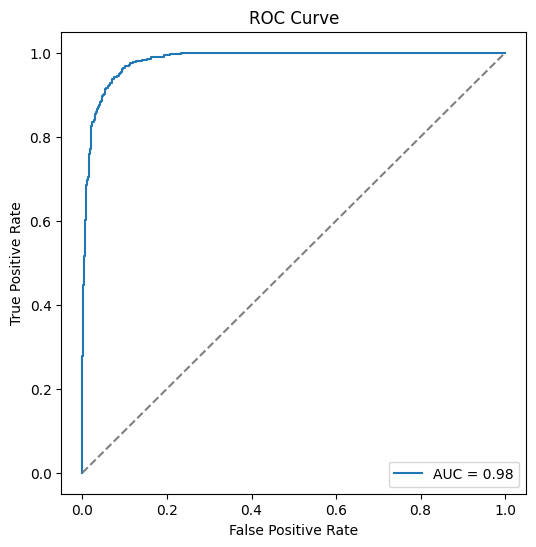

In [64]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc_score = roc_auc_score(y_test, y_pred_prob)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

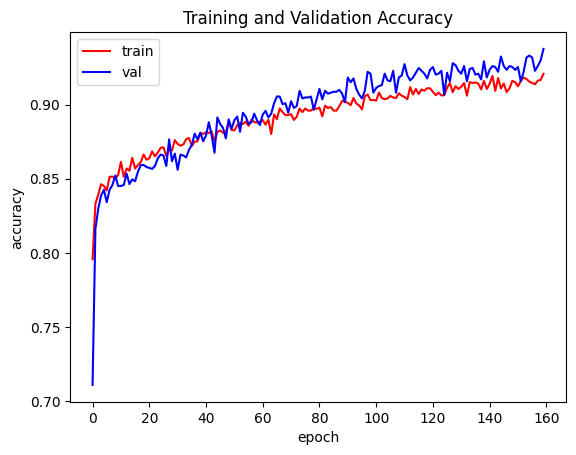

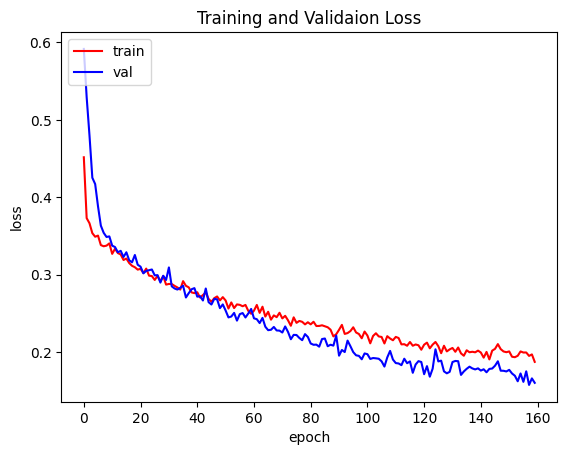

In [65]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

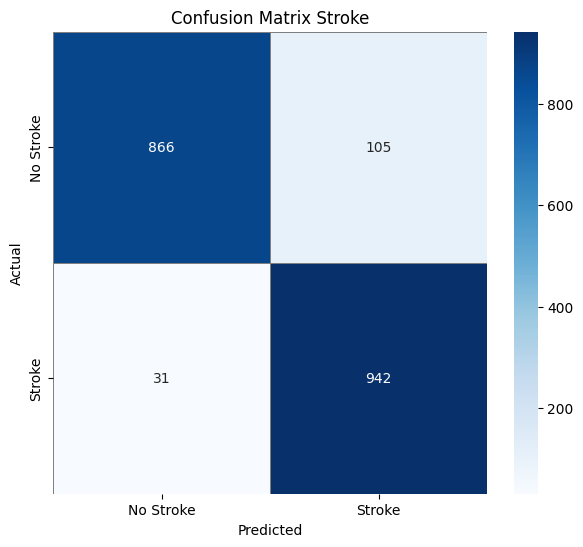

              precision    recall  f1-score   support

   No Stroke     0.9654    0.8919    0.9272       971
      Stroke     0.8997    0.9681    0.9327       973

    accuracy                         0.9300      1944
   macro avg     0.9326    0.9300    0.9299      1944
weighted avg     0.9325    0.9300    0.9299      1944



In [66]:
target_names = ['No Stroke', 'Stroke']
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names, linewidths=.5, linecolor='gray')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Stroke')
plt.show()

y_cr = classification_report(y_test, y_pred, target_names=target_names, digits=4)
print(y_cr)

## Konversi Model

In [67]:
model.save("model.h5")

In [68]:
!pip install tensorflowjs

In [69]:
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

2025-06-09 05:20:08.814758: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749446408.839354    7996 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749446408.846610    7996 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file
